In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
import scipy.cluster.hierarchy as sch

In [2]:
data = pd.read_csv(r"F:\Data Science\Assignments\7.Clustering\crime_data.csv")

In [3]:
data

,Unnamed: 0,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6
5,Colorado,7.9,204,78,38.7
6,Connecticut,3.3,110,77,11.1
7,Delaware,5.9,238,72,15.8
8,Florida,15.4,335,80,31.9
9,Georgia,17.4,211,60,25.8


# Data pre-processing / exploration

In [4]:
data.shape

(50, 5)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  50 non-null     object 
 1   Murder      50 non-null     float64
 2   Assault     50 non-null     int64  
 3   UrbanPop    50 non-null     int64  
 4   Rape        50 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.1+ KB


In [6]:
data.isna().sum()

Unnamed: 0    0
Murder        0
Assault       0
UrbanPop      0
Rape          0
dtype: int64

In [7]:
data.duplicated().sum()

0

In [9]:
data.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


In [10]:
#Dropping column unnamed as it will contribute much for clustering

data.drop(['Unnamed: 0'],axis=1, inplace=True)

# EDA

<AxesSubplot:>

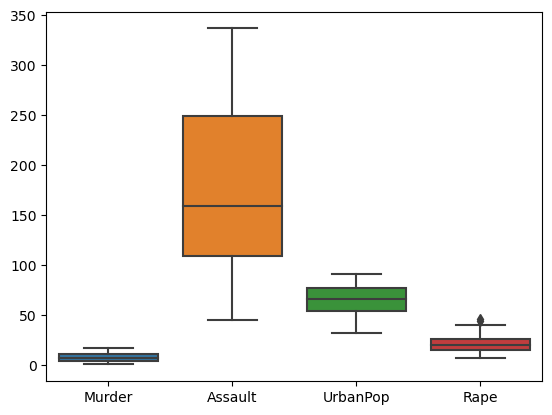

In [18]:
sns.boxplot(data=data)

C:\Users\LENOVO\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Rape'>

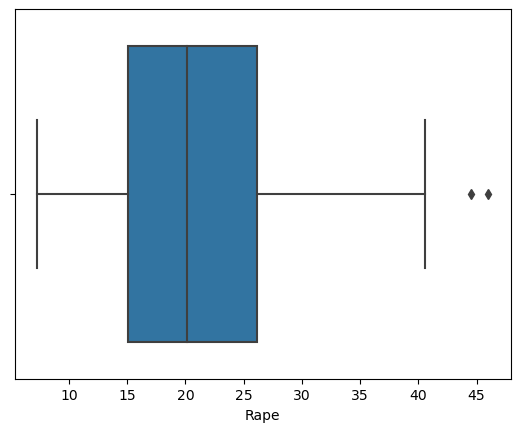

In [21]:
sns.boxplot(data.Rape)

In [24]:
#detecting outliers

q1,q3 = np.percentile(data['Rape'],[25,75])
print(q1,q3)

15.075 26.175


In [26]:
iqr = q3-q1
print('IQR :', iqr)

IQR : 11.100000000000001


In [27]:
lower_limit = q1-(1.5*iqr)
upper_limit = q3+(1.5*iqr)

print('Upper Limit:', upper_limit, "Lower_limit:", lower_limit)

Upper Limit: 42.825 Lower_limit: -1.5750000000000028


In [28]:
data[data['Rape']>42.825]

,Murder,Assault,UrbanPop,Rape
1,10.0,263,48,44.5
27,12.2,252,81,46.0


In [29]:
# Checking correlation
data.corr()

,Murder,Assault,UrbanPop,Rape
Murder,1.000000,0.801873,0.069573,0.563579
Assault,0.801873,1.000000,0.258872,0.665241
UrbanPop,0.069573,0.258872,1.000000,0.411341
Rape,0.563579,0.665241,0.411341,1.000000


In [32]:
df_std = StandardScaler().fit_transform(data)

df_std = pd.DataFrame(df_std, columns=data.columns)

# K-Means

In [35]:
error = []
for i in range(1,11):
    kmeans=KMeans(n_clusters=i, random_state=13)
    kmeans.fit(df_std)
    error.append(kmeans.inertia_)

C:\Users\LENOVO\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [37]:
error

[200.0,
 104.96163315756871,
 79.95548163171664,
 57.55425863091104,
 49.969202844527935,
 44.541884760296455,
 39.44879101757742,
 36.53227905990805,
 32.28374914882532,
 29.294746515972374]

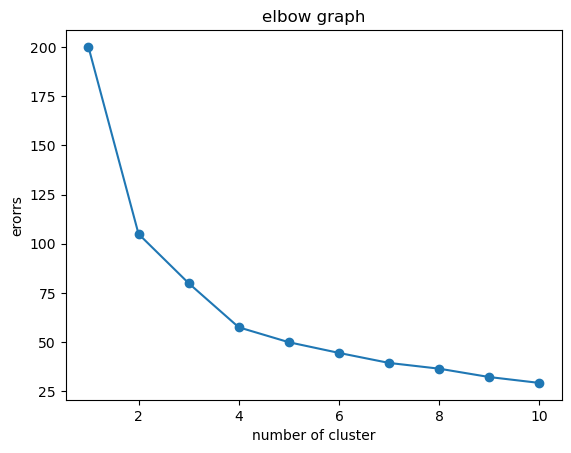

In [36]:
# elbow method

plt.plot(range(1,11), error, marker='o')
plt.title('elbow graph')
plt.xlabel('number of cluster')
plt.ylabel('erorrs')
plt.show()

In [39]:
#makeing cluster with k=4

kmeans4 = KMeans(n_clusters=4, random_state=42).fit(df_std)

In [40]:
kmeans4.labels_

array([1, 2, 2, 1, 2, 2, 0, 0, 2, 1, 0, 3, 2, 0, 3, 0, 3, 1, 3, 2, 0, 2,
       3, 1, 2, 3, 3, 2, 3, 0, 2, 2, 1, 3, 0, 0, 0, 0, 0, 1, 3, 1, 2, 0,
       3, 0, 0, 3, 3, 0])

In [41]:
kmeans4.cluster_centers_

array([[-0.49440658, -0.3864845 ,  0.58167593, -0.26431024],
       [ 1.42622412,  0.88321132, -0.82279055,  0.01946669],
       [ 0.70212683,  1.04999438,  0.72997363,  1.28990383],
       [-0.97130281, -1.11783581, -0.93954982, -0.97657842]])

In [47]:
data['cluster4_id']= kmeans4.labels_

In [48]:
data

,Murder,Assault,UrbanPop,Rape,cluster4_id
0,13.2,236,58,21.2,1
1,10.0,263,48,44.5,2
2,8.1,294,80,31.0,2
3,8.8,190,50,19.5,1
4,9.0,276,91,40.6,2
5,7.9,204,78,38.7,2
6,3.3,110,77,11.1,0
7,5.9,238,72,15.8,0
8,15.4,335,80,31.9,2
9,17.4,211,60,25.8,1


In [49]:
data.groupby('cluster4_id').agg(['mean']).reset_index()

,cluster4_id,Murder,Assault,UrbanPop,Rape
,,mean,mean,mean,mean
0,0,5.656250,138.875000,73.875000,18.781250
1,1,13.937500,243.625000,53.750000,21.412500
2,2,10.815385,257.384615,76.000000,33.192308
3,3,3.600000,78.538462,52.076923,12.176923


# Hierarchical Clustering

In [52]:
crime= data

In [54]:
crime.drop(['Unnamed: 0'], axis=1, inplace=True)

In [55]:
crime_norm = MinMaxScaler().fit_transform(crime)

In [58]:
crime_norm = pd.DataFrame(crime_norm, columns= crime.columns)

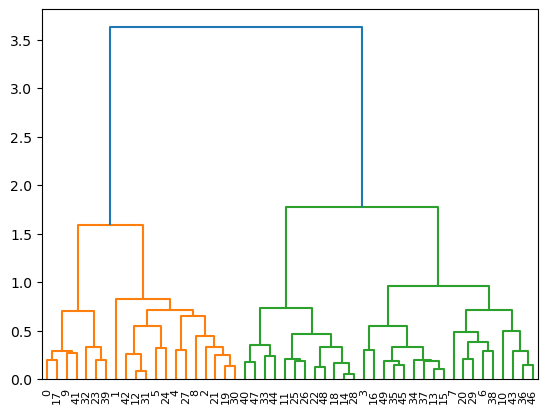

In [59]:
den_crime = sch.dendrogram(sch.linkage(crime_norm, method='ward'))

In [60]:
hc_crime = AgglomerativeClustering(n_clusters=4, affinity= 'euclidean', linkage='ward')

In [62]:
y_crime = hc_crime.fit_predict(crime_norm)
y_crime

array([3, 1, 1, 0, 1, 1, 0, 0, 1, 3, 0, 2, 1, 0, 2, 0, 0, 3, 2, 1, 0, 1,
       2, 3, 1, 2, 2, 1, 2, 0, 1, 1, 3, 2, 0, 0, 0, 0, 0, 3, 2, 3, 1, 0,
       2, 0, 0, 2, 2, 0], dtype=int64)

In [63]:
crime['cluster_id'] = y_crime

In [65]:
crime['cluster_id'].value_counts()

0    18
1    13
2    12
3     7
Name: cluster_id, dtype: int64

In [69]:
crime.groupby('cluster_id').agg(['mean']).reset_index()

,cluster_id,Murder,Assault,UrbanPop,Rape
,,mean,mean,mean,mean
0,0,6.055556,140.055556,71.333333,18.683333
1,1,10.815385,257.384615,76.000000,33.192308
2,2,3.091667,76.000000,52.083333,11.833333
3,3,14.671429,251.285714,54.285714,21.685714


# DBSCAN

In [88]:
df = pd.read_csv(r"F:\Data Science\Assignments\7.Clustering\crime_data.csv")

In [89]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)


In [107]:
df.head()

,Murder,Assault,UrbanPop,Rape
0,13.2,236,58,21.2
1,10.0,263,48,44.5
2,8.1,294,80,31.0
3,8.8,190,50,19.5
4,9.0,276,91,40.6


In [108]:
df_std = StandardScaler().fit_transform(df)
df_std

array([[ 1.25517927,  0.79078716, -0.52619514, -0.00345116],
       [ 0.51301858,  1.11805959, -1.22406668,  2.50942392],
       [ 0.07236067,  1.49381682,  1.00912225,  1.05346626],
       [ 0.23470832,  0.23321191, -1.08449238, -0.18679398],
       [ 0.28109336,  1.2756352 ,  1.77678094,  2.08881393],
       [ 0.02597562,  0.40290872,  0.86954794,  1.88390137],
       [-1.04088037, -0.73648418,  0.79976079, -1.09272319],
       [-0.43787481,  0.81502956,  0.45082502, -0.58583422],
       [ 1.76541475,  1.99078607,  1.00912225,  1.1505301 ],
       [ 2.22926518,  0.48775713, -0.38662083,  0.49265293],
       [-0.57702994, -1.51224105,  1.21848371, -0.11129987],
       [-1.20322802, -0.61527217, -0.80534376, -0.75839217],
       [ 0.60578867,  0.94836277,  1.21848371,  0.29852525],
       [-0.13637203, -0.70012057, -0.03768506, -0.0250209 ],
       [-1.29599811, -1.39102904, -0.5959823 , -1.07115345],
       [-0.41468229, -0.67587817,  0.03210209, -0.34856705],
       [ 0.44344101, -0.

In [109]:
df_std = pd.DataFrame(df_std)

In [125]:
dbscan = DBSCAN(eps=1, min_samples=4)
dbscan.fit_predict(df_std)

array([ 0, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1,  1, -1,  1,  1,  1,  1,
        0,  1, -1,  1, -1,  1, -1,  1,  1,  1, -1,  1,  1, -1, -1, -1,  1,
        1,  1,  1,  1,  1,  0,  1,  0, -1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int64)

In [126]:
dbscan.labels_

array([ 0, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1,  1, -1,  1,  1,  1,  1,
        0,  1, -1,  1, -1,  1, -1,  1,  1,  1, -1,  1,  1, -1, -1, -1,  1,
        1,  1,  1,  1,  1,  0,  1,  0, -1,  1,  1,  1,  1,  1,  1,  1],
      dtype=int64)

In [127]:
df['Cluster'] = dbscan.labels_
df

,Murder,Assault,UrbanPop,Rape,Cluster
0,13.2,236,58,21.2,0
1,10.0,263,48,44.5,-1
2,8.1,294,80,31.0,-1
3,8.8,190,50,19.5,-1
4,9.0,276,91,40.6,-1
5,7.9,204,78,38.7,-1
6,3.3,110,77,11.1,1
7,5.9,238,72,15.8,-1
8,15.4,335,80,31.9,-1
9,17.4,211,60,25.8,-1


In [128]:
df.groupby('Cluster').agg(['mean']).reset_index()

,Cluster,Murder,Assault,UrbanPop,Rape
,,mean,mean,mean,mean
0,-1,11.005556,247.166667,70.666667,28.766667
1,0,14.050000,238.000000,57.750000,23.200000
2,1,4.825000,112.035714,63.357143,16.107143


In [129]:
df['Cluster'].value_counts()

 1    28
-1    18
 0     4
Name: Cluster, dtype: int64

In [130]:
df

,Murder,Assault,UrbanPop,Rape,Cluster
0,13.2,236,58,21.2,0
1,10.0,263,48,44.5,-1
2,8.1,294,80,31.0,-1
3,8.8,190,50,19.5,-1
4,9.0,276,91,40.6,-1
5,7.9,204,78,38.7,-1
6,3.3,110,77,11.1,1
7,5.9,238,72,15.8,-1
8,15.4,335,80,31.9,-1
9,17.4,211,60,25.8,-1
